In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Definir las rutas de las carpetas y del archivo Excel
base_path = 'C:\\Dataset\\datosprep'
folders = {'A': 'Alzheimer', 'sanos': 'Healthy', 'otros': 'Other'}
mmse_file_path = 'C:\\Dataset\\MMSE_Score.xlsx'

# Cargar el archivo Excel con los MMSE scores
mmse_df = pd.read_excel(mmse_file_path)

# Inicializar listas para los datos, frecuencias de muestreo, etiquetas y MMSE scores
data = []
sampling_rates = []
labels = []
mmse_scores = []

# Función para cargar datos de una carpeta específica
def load_data_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder_path, filename)
            mat = sio.loadmat(file_path)
            eeg_data_key = 'datos'  # La clave correcta para los datos EEG
            if eeg_data_key in mat:
                eeg_data = mat[eeg_data_key]
                if isinstance(eeg_data, np.ndarray) and eeg_data.size > 0:
                    eeg_data = eeg_data[0, 0]  # Asegurar el acceso a la estructura correcta
                    if 'fs' in eeg_data.dtype.names and 'data' in eeg_data.dtype.names:
                        fs = eeg_data['fs'][0][0]
                        eeg_signals = eeg_data['data']
                        data.append(eeg_signals)
                        sampling_rates.append(fs)
                        labels.append(label)
                        
                        # Buscar el MMSE score correspondiente
                        mmse_score = mmse_df.loc[mmse_df['archivo'] == filename, 'MMSE']
                        if not mmse_score.empty:
                            mmse_scores.append(mmse_score.values[0])
                        else:
                            mmse_scores.append(-1)  # Usar -1 para indicar la falta de MMSE score
                    else:
                        print(f"Estructura de 'datos' en {filename} no es la esperada.")
                else:
                    print(f"La estructura de 'datos' en {filename} no es la esperada o está vacía.")
            else:
                print(f"La clave '{eeg_data_key}' no se encontró en el archivo {filename}")

# Cargar datos de todas las carpetas
for folder_name, label in folders.items():
    folder_path = os.path.join(base_path, folder_name)
    load_data_from_folder(folder_path, label)

# Verificar las formas de los datos cargados
for i, item in enumerate(data):
    print(f"Shape of data[{i}]: {item.shape}")

# Filtrar los datos que tienen formas anómalas
filtered_data = []
filtered_labels = []
filtered_mmse_scores = []

for i in range(len(data)):
    if data[i].shape == (19, 2000, 3):
        filtered_data.append(data[i])
        filtered_labels.append(labels[i])
        filtered_mmse_scores.append(mmse_scores[i])

data = filtered_data
labels = filtered_labels
mmse_scores = filtered_mmse_scores

if not data:
    raise ValueError("No data available with the expected shape (19, 2000, 3). Please check the dataset.")

# Convertir datos a la forma (samples, channels, time_steps, features)
data = np.stack(data)
print(f'Data stacked shape: {data.shape}')  # Verificar la forma después de apilar los datos

# Convertir las etiquetas a números (0: Alzheimer's, 1: Healthy, 2: Other)
label_mapping = {'Alzheimer': 0, 'Healthy': 1, 'Other': 2}
numeric_labels = np.array([label_mapping[label] for label in labels])

# Verificar la estructura final de 'data', 'labels' y 'mmse_scores'
print(f'Final shape of data: {data.shape}')
print(f'Labels: {numeric_labels}')
print(f'MMSE Scores: {mmse_scores[:10]}')  # Mostrar algunos MMSE scores para verificar

# Normalizar los MMSE scores (ignorar -1 si existen MMSE scores válidos)
mmse_scores = np.array(mmse_scores)
mmse_available = mmse_scores != -1  # Crear un indicador de disponibilidad

if np.any(mmse_available):  # Verificar si hay MMSE scores válidos
    mmse_min = np.min(mmse_scores[mmse_available])
    mmse_max = np.max(mmse_scores[mmse_available])
    mmse_scores[mmse_available] = (mmse_scores[mmse_available] - mmse_min) / (mmse_max - mmse_min)

# Expandir y replicar MMSE scores y disponibilidad para que coincidan con las dimensiones de los datos EEG
mmse_scores_expanded = np.expand_dims(mmse_scores, axis=(1, 2, 3))
mmse_scores_expanded = np.tile(mmse_scores_expanded, (1, data.shape[1], data.shape[2], 1))

mmse_available_expanded = np.expand_dims(mmse_available.astype(float), axis=(1, 2, 3))
mmse_available_expanded = np.tile(mmse_available_expanded, (1, data.shape[1], data.shape[2], 1))

# Concatenar los datos EEG con los MMSE scores y su disponibilidad
data_with_mmse = np.concatenate([data, mmse_scores_expanded, mmse_available_expanded], axis=3)
print(f'Data with MMSE: {data_with_mmse.shape}')  # Verificación adicional

# Convertir las etiquetas a formato categórico
y_categorical = to_categorical(numeric_labels, num_classes=3)
print(f'Categorical Labels Shape: {y_categorical.shape}')  # Verificación adicional

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_with_mmse, y_categorical, test_size=0.2, random_state=42, stratify=numeric_labels)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')  # Verificación adicional
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')  # Verificación adicional

# Normalizar los datos
scaler = StandardScaler()
# Aplicar el escalador a cada muestra por separado
X_train = np.array([scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X_train])
X_test = np.array([scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X_test])


Shape of data[0]: (19, 2000, 3)
Shape of data[1]: (19, 2000, 3)
Shape of data[2]: (19, 2000, 3)
Shape of data[3]: (19, 2000, 3)
Shape of data[4]: (19, 2000, 3)
Shape of data[5]: (19, 467910)
Shape of data[6]: (19, 2000, 3)
Shape of data[7]: (19, 2000, 3)
Shape of data[8]: (19, 2000, 3)
Shape of data[9]: (19, 2000, 3)
Shape of data[10]: (19, 2000, 3)
Shape of data[11]: (19, 2000, 3)
Shape of data[12]: (19, 2000, 3)
Shape of data[13]: (19, 2000, 3)
Shape of data[14]: (19, 2000, 3)
Shape of data[15]: (19, 2000, 3)
Shape of data[16]: (19, 2000, 3)
Shape of data[17]: (19, 2000, 3)
Shape of data[18]: (19, 2000, 3)
Shape of data[19]: (19, 2000, 3)
Shape of data[20]: (19, 2000, 3)
Shape of data[21]: (19, 2000, 3)
Shape of data[22]: (19, 2000, 3)
Shape of data[23]: (19, 2000, 3)
Shape of data[24]: (19, 2000, 3)
Shape of data[25]: (19, 2000, 3)
Shape of data[26]: (19, 2000, 3)
Shape of data[27]: (19, 2000, 3)
Shape of data[28]: (19, 2000, 3)
Shape of data[29]: (19, 2000, 3)
Shape of data[30]: (1

In [8]:
import numpy as np
from scipy.signal import welch
from scipy.stats import entropy
import scipy.io as sio

# Implementación manual de la dimensión fractal de Katz
def katz_fd(signal):
    L = np.sum(np.sqrt(np.diff(signal)**2 + 1))  # Longitud de la curva
    d = np.max(np.sqrt((np.arange(len(signal)) - np.argmin(signal))**2 + (signal - np.min(signal))**2))  # Distancia máxima desde el primer punto
    N = len(signal)
    return np.log10(N) / (np.log10(N) + np.log10(d / L))

# Función para calcular la dimensión fractal de Petrosian
def petrosian_fd(signal):
    N = len(signal)
    diff = np.diff(signal)
    N_delta = np.sum(diff[:-1] * diff[1:] < 0)
    return np.log(N) / (np.log(N) + np.log(N / (N + 0.4 * N_delta)))

# Función para calcular la movilidad de Hjorth
def hjorth_mobility(signal):
    return np.std(np.diff(signal)) / np.std(signal)

# Función para calcular la complejidad de Hjorth
def hjorth_complexity(signal):
    return hjorth_mobility(np.diff(signal)) / hjorth_mobility(signal)

# Función para calcular las potencias de banda
def band_powers(eeg_data, fs):
    features = []
    for channel in range(eeg_data.shape[1]):  # Iterar sobre los canales
        nperseg = min(256, eeg_data.shape[0])
        if nperseg < 3:  # Asegurarse de que nperseg sea lo suficientemente grande
            continue
        freqs, psd = welch(eeg_data[:, channel], fs=fs, nperseg=nperseg)
        if len(freqs) == 0 or len(psd) == 0:  # Verificación adicional
            continue
        if freqs.shape != psd.shape:
            print(f"Frequency and PSD shape mismatch: {freqs.shape} vs {psd.shape}")
            continue
        delta = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
        theta = np.sum(psd[(freqs >= 4) & (freqs < 8)])
        alpha = np.sum(psd[(freqs >= 8) & (freqs < 12)])
        beta = np.sum(psd[(freqs >= 12) & (freqs < 30)])
        gamma = np.sum(psd[(freqs >= 30) & (freqs <= 100)])
        features.extend([delta, theta, alpha, beta, gamma])
    return features

# Función para calcular todas las características relevantes
def extract_all_features(eeg_data, fs):
    features = []
    # Potencias de banda
    features.extend(band_powers(eeg_data, fs))
    for channel in range(eeg_data.shape[1]):  # Iterar sobre los canales
        channel_data = eeg_data[:, channel]  # Tomar la columna del canal
        # Estadísticas temporales
        features.extend([np.mean(channel_data), np.std(channel_data), np.var(channel_data)])
        # Entropía permutacional y espectral
        try:
            pe = entropy(np.histogram(channel_data, bins=3)[0])  # Simple permutation entropy placeholder
        except ValueError:
            pe = np.nan
        features.extend([pe, entropy(channel_data)])
        # Dimensiones fractales
        try:
            pfd = petrosian_fd(channel_data)
            kfd = katz_fd(channel_data)  # Usar la implementación manual
        except ValueError:
            pfd = kfd = np.nan
        features.extend([pfd, kfd])
        # Parámetros de Hjorth
        try:
            mobility = hjorth_mobility(channel_data)
            complexity = hjorth_complexity(channel_data)
        except ValueError:
            mobility = complexity = np.nan
        features.extend([mobility, complexity])
    return features

# Ajustar la extracción de datos para manejar la estructura de los archivos .mat
def adjust_data_structure(data):
    if isinstance(data, np.ndarray):
        if data.shape == (1, 1):
            return data[0, 0]
        elif data.shape == (1,):
            return data[0]
    return data

# Simulación de la carga de datos
# Aquí debes cargar tus datos .mat, por ejemplo:
# data = sio.loadmat('ruta_a_tu_archivo.mat')['variable']
data = [np.random.rand(1000, 19) for _ in range(66)]  # Simulación de datos
sampling_rates = [1000 for _ in range(66)]  # Simulación de tasas de muestreo

# Verificar la estructura de 'data'
print(f'Length of data: {len(data)}')
print(f'Sample data shape: {data[0].shape if len(data) > 0 else "No data"}')

# Ajustar los datos
adjusted_data = [adjust_data_structure(d) for d in data]
adjusted_fs = [adjust_data_structure(fs) for fs in sampling_rates]

# Verificar las formas después del ajuste
print(f'Adjusted sample data shape: {adjusted_data[0].shape if len(adjusted_data) > 0 else "No data"}')
print(f'Adjusted sampling rates: {adjusted_fs}')

# Extraer características de todos los datos
all_features = []
for eeg, fs in zip(adjusted_data, adjusted_fs):
    if isinstance(eeg, np.ndarray) and eeg.size > 0:
        features = extract_all_features(eeg, fs)
        if features:
            all_features.append(features)

# Verificar la cantidad de características extraídas por cada muestra
for i, features in enumerate(all_features):
    print(f'Sample {i} feature length: {len(features)}')

# Función para obtener la longitud máxima de las listas en all_features
def get_max_length(features_list):
    return max(len(features) for features in features_list)

# Función para paddear las listas más cortas
def pad_features(features_list, max_length):
    padded_features = []
    for features in features_list:
        if len(features) < max_length:
            # Padding con ceros (o cualquier valor que consideres apropiado)
            features.extend([0] * (max_length - len(features)))
        padded_features.append(features)
    return padded_features

# Obtener la longitud máxima de las listas de características
max_length = get_max_length(all_features)

# Paddear las listas de características
padded_features = pad_features(all_features, max_length)

# Convertir la lista paddeada en un array de numpy
X = np.array(padded_features)
print(f'Shape of feature array X: {X.shape}')


Length of data: 66
Sample data shape: (1000, 19)
Adjusted sample data shape: (1000, 19)
Adjusted sampling rates: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Sample 0 feature length: 266
Sample 1 feature length: 266
Sample 2 feature length: 266
Sample 3 feature length: 266
Sample 4 feature length: 266
Sample 5 feature length: 266
Sample 6 feature length: 266
Sample 7 feature length: 266
Sample 8 feature length: 266
Sample 9 feature length: 266
Sample 10 feature length: 266
Sample 11 feature length: 266
Sample 12 feature length: 266
Sample 13 feature length: 266
Sample 14 feature length: 266
Sample 15 feature length: 266
Sample 16 feature le

Numeric Labels: [0 0 0 0 0 0 0 0 0 0]
Categorical Labels Shape: (69, 3)
X reshaped: (69, 14, 19)
X_train: (55, 14, 19), X_test: (14, 14, 19)
y_train: (55, 3), y_test: (14, 3)
Checking for NaNs in X_train: True
Checking for infinities in X_train: True
Checking for NaNs in X_test: True
Checking for infinities in X_test: True
Checking for NaNs in X_train after cleaning: False
Checking for infinities in X_train after cleaning: False
Checking for NaNs in X_test after cleaning: False
Checking for infinities in X_test after cleaning: False


c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model i

c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model i

Best Parameters: {'model__optimizer': 'adam', 'model__kernel_size': 3, 'model__filters': 64, 'model__dropout_rate': 0.3, 'model__dense_units': 128, 'epochs': 100, 'batch_size': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4286 - loss: 10.6719
Accuracy: 0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Confusion Matrix:
[[0 6 0]
 [0 6 0]
 [1 1 0]]
Classification Report:
              precision    recall  f1-score   support

   Alzheimer       0.00      0.00      0.00         6
     Healthy       0.46      1.00      0.63         6
       Other       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.15      0.33      0.21        14
weighted avg       0.20      0.43      0.27        14



c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mario\miniconda3\envs\tecmx\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


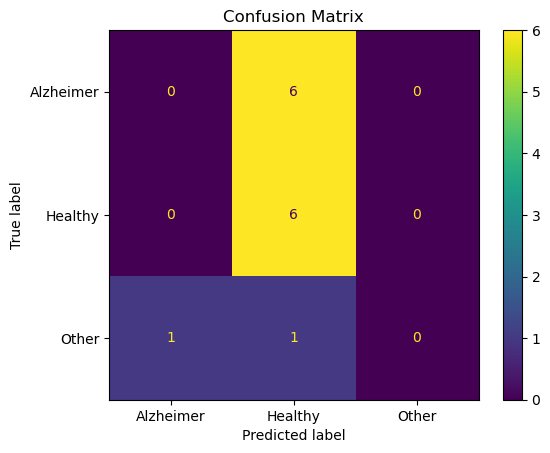

Model saved to eeg_model_best.h5
Training history saved to training_history.json


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
import lime
import lime.lime_tabular
import shap

# Convertir las etiquetas a una representación categórica
print(f'Numeric Labels: {numeric_labels[:10]}')  # Verificación adicional
y_categorical = to_categorical(numeric_labels, num_classes=3)
print(f'Categorical Labels Shape: {y_categorical.shape}')  # Verificación adicional

# Asegurar que los datos tengan la forma adecuada para una CNN (samples, time_steps, channels)
X_reshaped = X.reshape(X.shape[0], X.shape[1] // 19, 19)
print(f'X reshaped: {X_reshaped.shape}')  # Verificación adicional

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42, stratify=numeric_labels)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')  # Verificación adicional
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')  # Verificación adicional

# Verificar NaN e infinitos en X_train y X_test
print("Checking for NaNs in X_train:", np.isnan(X_train).any())
print("Checking for infinities in X_train:", np.isinf(X_train).any())
print("Checking for NaNs in X_test:", np.isnan(X_test).any())
print("Checking for infinities in X_test:", np.isinf(X_test).any())

# Imputar o eliminar valores inválidos si se encuentran
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)

# Verificar nuevamente para asegurarse de que no hay valores NaN o infinitos
print("Checking for NaNs in X_train after cleaning:", np.isnan(X_train).any())
print("Checking for infinities in X_train after cleaning:", np.isinf(X_train).any())
print("Checking for NaNs in X_test after cleaning:", np.isnan(X_test).any())
print("Checking for infinities in X_test after cleaning:", np.isinf(X_test).any())

# Construcción del modelo CNN con técnicas de regularización
def create_model(filters=32, kernel_size=3, dense_units=128, dropout_rate=0.5, optimizer='adam'):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l1_l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l1_l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l1_l2(0.01)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')  # 3 clases
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Ajuste de hiperparámetros
model = KerasClassifier(model=create_model, verbose=0)
param_dist = {
    'model__filters': [32, 64],
    'model__kernel_size': [3, 5],
    'model__dense_units': [128, 256],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=3, random_state=42)
random_search_result = random_search.fit(X_train, y_train, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Mejor modelo
best_model = random_search_result.best_estimator_.model_
print(f"Best Parameters: {random_search_result.best_params_}")

# Evaluar el mejor modelo
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Matriz de confusión y reporte de clasificación
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_true_classes, y_pred_classes, target_names=['Alzheimer', 'Healthy', 'Other'])
print("Classification Report:")
print(class_report)

# Visualización de la matriz de confusión
ConfusionMatrixDisplay(conf_matrix, display_labels=['Alzheimer', 'Healthy', 'Other']).plot()
plt.title('Confusion Matrix')
plt.show()

# Guardar el modelo y el historial del entrenamiento
model_save_path = 'eeg_model_best.h5'
best_model.save(model_save_path)
print(f'Model saved to {model_save_path}')

history_save_path = 'training_history.json'
with open(history_save_path, 'w') as f:
    json.dump(random_search_result.best_estimator_.model_.history.history, f)
print(f'Training history saved to {history_save_path}')
